# Grating coupler

Run this notebook in your browser using [Binder](https://mybinder.org/v2/gh/flexcompute-readthedocs/tidy3d-docs/readthedocs?labpath=docs%2Fsource%2Fnotebooks%2FGratingCoupler.ipynb). View this project in [Tidy3D Web App](https://tidy3d.simulation.cloud/workbench?taskId=0a3c6fd8-ea93-4b82-af93-d981df53086e).

In [1]:
# basic imports
import numpy as np
import matplotlib.pylab as plt

# tidy3d imports
import tidy3d as td
import tidy3d.web as web


[18:27:10] INFO     Using client version: 1.8.1                               ]8;id=466592;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/__init__.py\__init__.py]8;;\:]8;id=626962;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/__init__.py#112\112]8;;\

## Problem Setup

In this example, we model a 3D grating coupler in a Silicon on Insulator (SOI) platform.

A basic schematic of the design is shown below.  The simulation is about 19um x 4um x 5um with a wavelength of 1.55um and takes about 1 minute to simulate 10,000 time steps.

In the simulation, we inject a modal source into the waveguide and propagate it towards the grating structure.  The radiation from the grating coupler is then measured with a near field monitor and we use a far field projection to inspect the angular dependence of the radiation.

<img src="img/grating_coupler.png" width=600>

In [2]:
# basic parameters (note, all length units are microns)
nm = 1e-3
wavelength = 1550 * nm

# grid specification
grid_spec = td.GridSpec.auto(min_steps_per_wvl=20, wavelength=wavelength)

# waveguide
wg_width = 400 * nm
wg_height = 220 * nm
wg_length = 2 * wavelength

# surrounding
sub_height = 2.0
air_height = 2.0
buffer = 0.5 * wavelength

# coupler
cp_width = 4 * wavelength
cp_length = 8 * wavelength
taper_length = 6 * wavelength


In [3]:
# sizes
Lx = buffer + wg_length + taper_length + cp_length
Ly = buffer + cp_width + buffer
Lz = sub_height + wg_height + air_height
sim_size = [Lx, Ly, Lz]

# convenience variables to store center of coupler and waveguide
wg_center_x = +Lx / 2 - buffer - (wg_length + taper_length) / 2
cp_center_x = -Lx / 2 + buffer + cp_length / 2
wg_center_z = -Lz / 2 + sub_height + wg_height / 2
cp_center_z = -Lz / 2 + sub_height + wg_height / 2

# materials
Air = td.Medium(permittivity=1.0)
Si = td.Medium(permittivity=3.47**2)
SiO2 = td.Medium(permittivity=1.44**2)

# source parameters
freq0 = td.C_0 / wavelength
fwidth = freq0 / 10
run_time = 100 / fwidth


## Mode Solve
To determine the pitch of the waveguide for a given design angle, we need to compute the effective index of the waveguide mode being coupled into.  For this, we set up a simple simulation of the coupler region and use the mode solver to get the effective index. We will not run this simulation, we just add a ``ModeMonitor`` object in order to call the mode solver, ``sim.compute_modes()`` below, and get the effective index of the wide-waveguide region.

[18:27:11] WARNING  No sources in simulation.                               ]8;id=260927;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=997394;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#494\494]8;;\

<AxesSubplot: title={'center': 'cross section at z=0.00'}, xlabel='x', ylabel='y'>

<Figure size 1080x216 with 3 Axes>

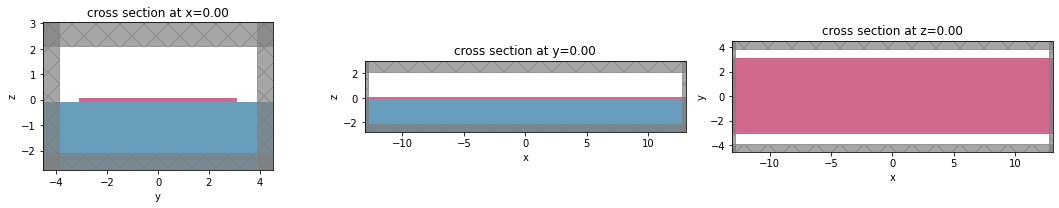

In [4]:
# grating parameters
design_theta_deg = -30
design_theta_rad = np.pi * design_theta_deg / 180
grating_height = 70 * nm

# do a mode solve to get neff of the coupler

sub = td.Structure(
    geometry=td.Box(center=[0, 0, -Lz / 2], size=[td.inf, td.inf, 2 * sub_height]),
    medium=SiO2,
    name="substrate",
)

cp = td.Structure(
    geometry=td.Box(
        center=[0, 0, cp_center_z - grating_height / 4],
        size=[td.inf, cp_width, wg_height - grating_height / 2],
    ),
    medium=Si,
    name="coupler",
)

mode_plane = td.Box(center=(0, 0, 0), size=(0, 8 * cp_width, 8 * wg_height))


sim = td.Simulation(
    size=sim_size,
    grid_spec=grid_spec,
    structures=[sub, cp],
    sources=[],
    monitors=[],
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
    run_time=1e-12,
)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(15, 3))
sim.plot(x=0, ax=ax1)
sim.plot(y=0, ax=ax2)
sim.plot(z=0, ax=ax3)


## Compute Effective index for Grating Pitch Design

In [5]:
from tidy3d.plugins import ModeSolver

ms = ModeSolver(
    simulation=sim, plane=mode_plane, mode_spec=td.ModeSpec(), freqs=[freq0]
)
mode_output = ms.solve()


<Figure size 1080x216 with 6 Axes>

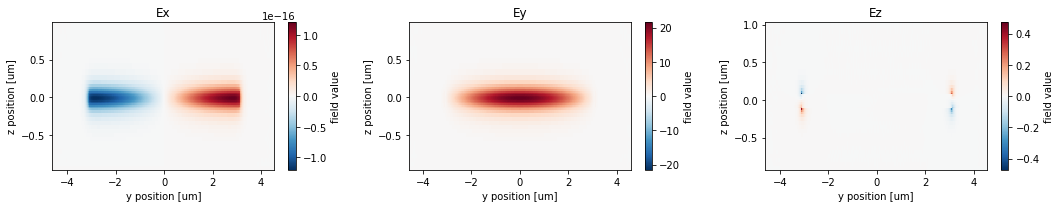

In [6]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(15, 3))
mode_output.Ex.real.plot(x="y", y="z", ax=ax1)
mode_output.Ey.real.plot(x="y", y="z", ax=ax2)
mode_output.Ez.real.plot(x="y", y="z", ax=ax3)
ax1.set_title("Ex")
ax2.set_title("Ey")
ax3.set_title("Ez")
plt.show()


In [7]:
neff = float(mode_output.n_eff)
print(f"effective index = {neff:.4f}")


effective index = 2.6885


## Create Simulation
Now we set up the grating coupler to simulate in Tidy3D.

In [8]:
# gratings
pitch = wavelength / (neff - np.sin(abs(design_theta_rad)))
grating_length = pitch / 2.0
num_gratings = int(cp_length / pitch)

sub = td.Structure(
    geometry=td.Box(
        center=[0, 0, -Lz / 2],
        size=[td.inf, td.inf, 2 * sub_height],
    ),
    medium=SiO2,
    name="substrate",
)

wg = td.Structure(
    geometry=td.Box(
        center=[wg_center_x, 0, wg_center_z],
        size=[buffer + wg_length + taper_length + cp_length / 2, wg_width, wg_height],
    ),
    medium=Si,
    name="waveguide",
)

cp = td.Structure(
    geometry=td.Box(
        center=[cp_center_x, 0, cp_center_z],
        size=[cp_length, cp_width, wg_height],
    ),
    medium=Si,
    name="coupler",
)

tp = td.Structure(
    geometry=td.PolySlab(
        vertices=[
            [cp_center_x + cp_length / 2 + taper_length, +wg_width / 2],
            [cp_center_x + cp_length / 2 + taper_length, -wg_width / 2],
            [cp_center_x + cp_length / 2, -cp_width / 2],
            [cp_center_x + cp_length / 2, +cp_width / 2],
        ],
        slab_bounds=(wg_center_z - wg_height / 2, wg_center_z + wg_height / 2),
        axis=2,
    ),
    medium=Si,
    name="taper",
)

grating_left_x = cp_center_x - cp_length / 2
gratings = [
    td.Structure(
        geometry=td.Box(
            center=[
                grating_left_x + (i + 0.5) * pitch,
                0,
                cp_center_z + wg_height / 2 - grating_height / 2,
            ],
            size=[grating_length, cp_width, grating_height],
        ),
        medium=Air,
        name=f"{i}th_grating",
    )
    for i in range(num_gratings)
]


In [9]:
# distance to near field monitor
nf_offset = 50 * nm

plane_monitor = td.FieldMonitor(
    center=[0, 0, cp_center_z],
    size=[td.inf, td.inf, 0],
    freqs=[freq0],
    name="full_domain_fields",
)

rad_monitor = td.FieldMonitor(
    center=[0, 0, 0], size=[td.inf, 0, td.inf], freqs=[freq0], name="radiated_fields"
)

near_field_monitor = td.FieldMonitor(
    center=[cp_center_x, 0, cp_center_z + wg_height / 2 + nf_offset],
    size=[td.inf, td.inf, 0],
    freqs=[freq0],
    name="radiated_near_fields",
)


In [10]:
sim = td.Simulation(
    size=sim_size,
    grid_spec=grid_spec,
    structures=[sub, wg, cp, tp] + gratings,
    sources=[],
    monitors=[plane_monitor, rad_monitor, near_field_monitor],
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
)


[18:27:13] WARNING  No sources in simulation.                               ]8;id=794251;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=318170;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#494\494]8;;\

### Make Modal Source

<Figure size 1080x216 with 6 Axes>

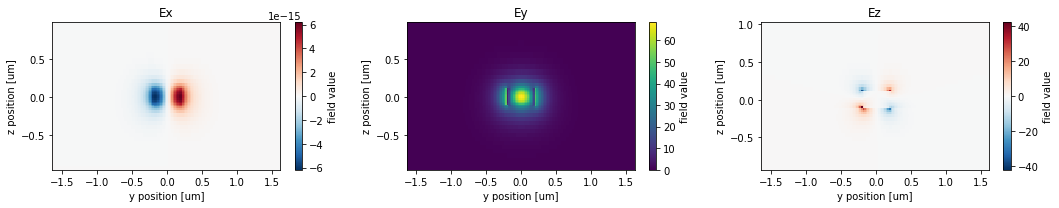

In [11]:
source_plane = td.Box(
    center=[Lx / 2 - buffer, 0, cp_center_z],
    size=[0, 8 * wg_width, 8 * wg_height],
)

ms = ModeSolver(
    simulation=sim, plane=source_plane, mode_spec=td.ModeSpec(), freqs=[freq0]
)
mode_output = ms.solve()

f, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(15, 3))
mode_output.Ex.real.plot(x="y", y="z", ax=ax1)
mode_output.Ey.real.plot(x="y", y="z", ax=ax2)
mode_output.Ez.real.plot(x="y", y="z", ax=ax3)
ax1.set_title("Ex")
ax2.set_title("Ey")
ax3.set_title("Ez")
plt.show()


In [12]:
source_time = td.GaussianPulse(freq0=freq0, fwidth=fwidth)
mode_src = ms.to_source(mode_index=0, direction="-", source_time=source_time)
sim = sim.copy(update={"sources": [mode_src]})


<Figure size 1008x216 with 3 Axes>

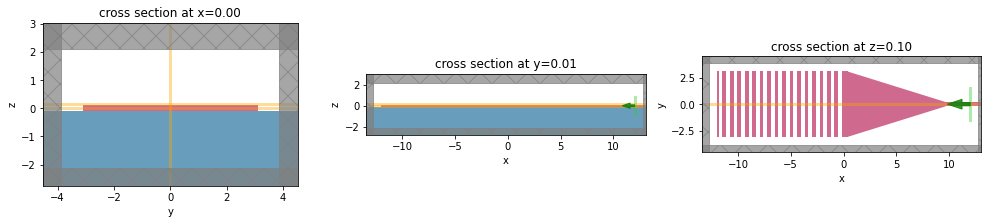

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(14, 3))
sim.plot(x=0, ax=ax1)
sim.plot(y=0.01, ax=ax2)
sim.plot(z=0.1, ax=ax3)
plt.show()


In [14]:
mode_src.help()


╭───────────────── <class 'tidy3d.components.source.ModeSource'> ─────────────────╮
│ Injects current source to excite modal profile on finite extent plane.          │
│                                                                                 │
│ ╭─────────────────────────────────────────────────────────────────────────────╮ │
│ │ ModeSource(                                                                 │ │
│ │ │   type='ModeSource',                                                      │ │
│ │ │   center=(12.012500000000001, 0.0, -3.191891195797325e-16),               │ │
│ │ │   size=(0.0, 3.2, 1.76),                                                  │ │
│ │ │   source_time=GaussianPulse(                                              │ │
│ │ │   │   amplitude=1.0,                                                      │ │
│ │ │   │   phase=0.0,                                                          │ │
│ │ │   │   type='GaussianPulse',                                               │ │
│ │ │   │   freq0=193414489116771.6,                                            │ │
│ │ │   │   fwidth=19341448911677.16,                                           │ │
│ │ │   │   offset=5.0                                                          │ │
│ │ │   ),                                                                      │ │
│ │ │   name=None,                                                              │ │
│ │ │   num_freqs=1,                                                            │ │
│ │ │   direction='-',                                                          │ │
│ │ │   mode_spec=ModeSpec(                                                     │ │
│ │ │   │   num_modes=1,                                                        │ │
│ │ │   │   target_neff=None,                                                   │ │
│ │ │   │   num_pml=(0, 0),                                                     │ │
│ │ │   │   filter_pol=None,                                                    │ │
│ │ │   │   angle_theta=0.0,                                                    │ │
│ │ │   │   angle_phi=0.0,                                                      │ │
│ │ │   │   precision='single',                                                 │ │
│ │ │   │   bend_radius=None,                                                   │ │
│ │ │   │   bend_axis=None,                                                     │ │
│ │ │   │   track_freq='central',                                               │ │
│ │ │   │   type='ModeSpec'                                                     │ │
│ │ │   ),                                                                      │ │
│ │ │   mode_index=0                                                            │ │
│ │ )                                                                           │ │
│ ╰─────────────────────────────────────────────────────────────────────────────╯ │
│                                                                                 │
│      angle_phi = 0.0                                                            │
│    angle_theta = 0.0                                                            │
│   bounding_box = Box(                                                           │
│                      type='Box',                                                │
│                      center=(                                                   │
│                          12.012500000000001,                                    │
│                          0.0,                                                   │
│                          -3.3306690738754696e-16                                │
│                      ),                                                         │
│                      size=(0.0, 3.2, 1.76)                                      │
│                  )                                                              │
│         bounds = (                                

## Run Simulation

Run the simulation and plot the field patterns

In [15]:
# create a project, upload to our server to run
job = web.Job(simulation=sim, task_name="grating_coupler")
sim_data = job.run(path="data/grating_coupler.hdf5")
print(sim_data.log)


[18:27:15] INFO     Using Tidy3D credentials from stored file.                     ]8;id=553911;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/auth.py\auth.py]8;;\:]8;id=593822;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/auth.py#70\70]8;;\

[18:27:16] INFO     Authentication successful.                                     ]8;id=294744;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/auth.py\auth.py]8;;\:]8;id=741568;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/auth.py#30\30]8;;\

           INFO     Created task 'grating_coupler' with task_id                 ]8;id=438102;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=17648;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#120\120]8;;\
                    '67ec2f14-8317-4157-88fd-4f201b5d2bdf'.                                  

Output()

[18:27:17] INFO     Maximum FlexUnit cost: 1.623                                ]8;id=989309;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=753531;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#252\252]8;;\

           INFO     status = queued                                             ]8;id=196455;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=399694;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#261\261]8;;\

Output()

[18:27:21] INFO     status = preprocess                                         ]8;id=374400;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=512754;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#273\273]8;;\

[18:27:29] INFO     starting up solver                                          ]8;id=178345;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=912331;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#277\277]8;;\

[18:27:40] INFO     running solver                                              ]8;id=557497;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=448353;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#283\283]8;;\

Output()

[18:28:06] INFO     early shutoff detected, exiting.                            ]8;id=154716;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=114442;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#294\294]8;;\

           INFO     status = postprocess                                        ]8;id=896582;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=845120;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#300\300]8;;\

Output()

[18:28:11] INFO     status = success                                            ]8;id=830437;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=5953;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#306\306]8;;\

[18:28:12] INFO     Billed FlexUnit cost: 0.459                                 ]8;id=73401;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=954704;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#310\310]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=839447;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=744867;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#592\592]8;;\
                    "data/grating_coupler.hdf5"                                              

Output()

[18:28:15] INFO     loading SimulationData from data/grating_coupler.hdf5       ]8;id=84564;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=868783;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#414\414]8;;\

Simulation domain Nx, Ny, Nz: [1157, 334, 102]
Applied symmetries: (0, 0, 0)
Number of computational grid points: 4.0500e+07.
Using subpixel averaging: True
Number of time steps: 1.3520e+05
Automatic shutoff factor: 1.00e-05
Time step (s): 3.8241e-17


Compute source modes time (s):     1.0350
Compute monitor modes time (s):    0.0035
Rest of setup time (s):            5.2935

Running solver for 135204 time steps...
- Time step   1076 / time 4.11e-14s (  0 % done), field decay: 1.00e+00
- Time step   5408 / time 2.07e-13s (  4 % done), field decay: 1.00e+00
- Time step  10816 / time 4.14e-13s (  8 % done), field decay: 1.75e-02
- Time step  16224 / time 6.20e-13s ( 12 % done), field decay: 3.27e-03
- Time step  21632 / time 8.27e-13s ( 16 % done), field decay: 2.48e-04
- Time step  27040 / time 1.03e-12s ( 20 % done), field decay: 6.94e-05
- Time step  32448 / time 1.24e-12s ( 24 % done), field decay: 2.09e-05
- Time step  37857 / time 1.45e-12s ( 28 % done), field decay: 6.40e-06
Fiel

<AxesSubplot: title={'center': 'cross section at y=0.00'}, xlabel='x', ylabel='z'>

<Figure size 1008x576 with 4 Axes>

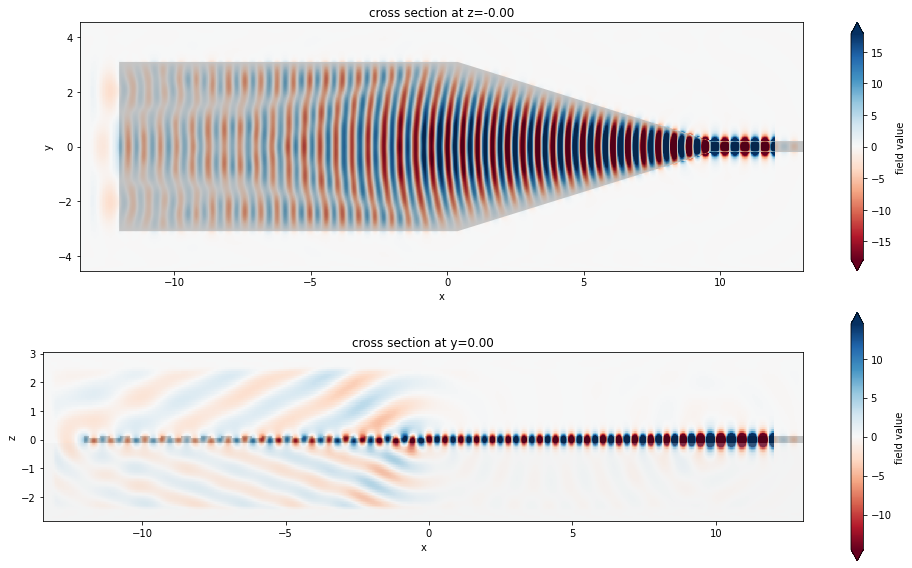

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, tight_layout=True, figsize=(14, 8))
sim_data.plot_field("full_domain_fields", "Ey", f=freq0, ax=ax1)
sim_data.plot_field("radiated_fields", "Ey", f=freq0, ax=ax2)


## Far Field Projection
Now we use the `Tidy3D`'s [FieldProjector](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.FieldProjector.html) to compute the anglular dependence of the far field scattering based on the near field monitor.

In [17]:
# create range of angles to probe (note: polar coordinates, theta = 0 corresponds to vertical (z axis))
num_angles = 1101
thetas = np.linspace(-np.pi / 2, np.pi / 2, num_angles)

# make a near-to-far monitor specifying the observation angles and frequencies of interest
monitor_n2f = td.FieldProjectionAngleMonitor(
    center=near_field_monitor.center,
    size=near_field_monitor.size,
    normal_dir="+",
    freqs=[freq0],
    theta=thetas,
    phi=[0.0],
    name="n2f",
)

# make a near field to far field projector with the near field monitor data
near_field_surface = td.FieldProjectionSurface(
    monitor=near_field_monitor, normal_dir="+"
)
n2f = td.FieldProjector(sim_data=sim_data, surfaces=[near_field_surface])

# compute the far_fields
far_fields = n2f.project_fields(monitor_n2f)

# Compute the scattered cross section
Ps = far_fields.radar_cross_section.sel(f=freq0).values[0, ...]


Output()

/home/momchil/miniconda3/envs/flex/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<Figure size 360x360 with 1 Axes>

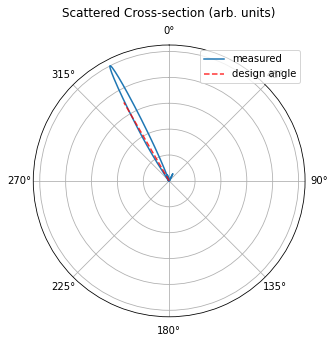

In [18]:
# plot the angle dependence
fig, ax = plt.subplots(subplot_kw={"projection": "polar"}, figsize=(5, 5))
ax.plot(thetas, np.abs(Ps), label="measured")
ax.plot(
    [design_theta_rad, design_theta_rad],
    [0, np.max(Ps) * 0.7],
    "r--",
    alpha=0.8,
    label="design angle",
)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_yticklabels([])
ax.set_title("Scattered Cross-section (arb. units)", va="bottom")
plt.legend()
plt.show()


In [19]:
print(f"expect angle of {(design_theta_rad * 180 / np.pi):.2f} degrees")
i_max = np.argmax(Ps)
print(f"got maximum angle of {(thetas[i_max] * 180 / np.pi):.2f} degrees")


expect angle of -30.00 degrees
got maximum angle of -27.16 degrees


The agreement between the target angle and the actual emission angle of the coupler is good. The small difference comes from the fact that the design is very sensitive to the value of the effective index that we use in the coupler region, and that value depends on which waveguide height we pick in that region: the one with the grating comb, or without. In our setup, we used a thickness that is at the mid-point, but this is a heuristic choice which results in the small final mismatch in angles observed here.

## Gaussian beam into the coupler

We can also run the coupler in the opposite way, injecting a Gaussian beam from above and monitoring the transmission into the waveguide. We will use the measured angle rather than the design angle to see the highest in-coupling efficiency that we can obtain.

In [20]:
gaussian_beam = td.GaussianBeam(
    size=(td.inf, td.inf, 0),
    center=[-8, 0, 2],
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    angle_theta=27.16 * np.pi / 180,
    angle_phi=np.pi,
    direction="-",
    waist_radius=2,
    pol_angle=np.pi / 2,
)

mode_mon = ms.to_monitor(freqs=[freq0], name="coupled")

flux_mon = td.FluxMonitor(
    size=mode_mon.size,
    center=mode_mon.center,
    freqs=[freq0],
    name="flux",
)


sim2 = td.Simulation(
    size=sim_size,
    grid_spec=grid_spec,
    structures=[sub, wg, cp, tp] + gratings,
    sources=[gaussian_beam],
    monitors=[plane_monitor, rad_monitor, mode_mon, flux_mon],
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
)


<Figure size 1008x216 with 3 Axes>

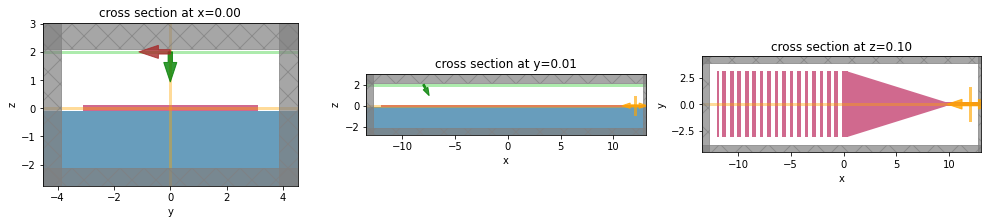

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(14, 3))
sim2.plot(x=0, ax=ax1)
sim2.plot(y=0.01, ax=ax2)
sim2.plot(z=0.1, ax=ax3)
plt.show()


In [22]:
job2 = web.Job(simulation=sim2, task_name="grating_coupler_beam")
sim_data2 = job2.run(path="data/grating_coupler.hdf5")
print(sim_data2.log)


[18:28:20] INFO     Created task 'grating_coupler_beam' with task_id            ]8;id=676024;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=788069;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#120\120]8;;\
                    '9916e40a-d4f1-48a4-aada-71f9ba162dcf'.                                  

Output()

[18:28:21] INFO     Maximum FlexUnit cost: 1.621                                ]8;id=117651;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=976906;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#252\252]8;;\

           INFO     status = queued                                             ]8;id=729718;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=640038;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#261\261]8;;\

Output()

[18:28:24] INFO     status = preprocess                                         ]8;id=196549;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=644461;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#273\273]8;;\

[18:28:33] INFO     starting up solver                                          ]8;id=479344;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=146792;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#277\277]8;;\

[18:28:44] INFO     running solver                                              ]8;id=139957;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=874398;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#283\283]8;;\

Output()

[18:29:03] INFO     early shutoff detected, exiting.                            ]8;id=353089;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=877226;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#294\294]8;;\

           INFO     status = postprocess                                        ]8;id=24554;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=396610;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#300\300]8;;\

Output()

[18:29:08] INFO     status = success                                            ]8;id=194026;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=468753;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#306\306]8;;\

[18:29:09] INFO     Billed FlexUnit cost: 0.263                                 ]8;id=753794;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=708191;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#310\310]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=344466;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=12693;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#592\592]8;;\
                    "data/grating_coupler.hdf5"                                              

Output()

[18:29:10] INFO     loading SimulationData from data/grating_coupler.hdf5       ]8;id=954103;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=398547;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#414\414]8;;\

Simulation domain Nx, Ny, Nz: [1157, 334, 102]
Applied symmetries: (0, 0, 0)
Number of computational grid points: 4.0500e+07.
Using subpixel averaging: True
Number of time steps: 1.3520e+05
Automatic shutoff factor: 1.00e-05
Time step (s): 3.8241e-17


Compute source modes time (s):     1.4109
Compute monitor modes time (s):    1.0113
Rest of setup time (s):            5.3472

Running solver for 135204 time steps...
- Time step   1076 / time 4.11e-14s (  0 % done), field decay: 1.00e+00
- Time step   5408 / time 2.07e-13s (  4 % done), field decay: 9.71e-03
- Time step  10816 / time 4.14e-13s (  8 % done), field decay: 1.59e-03
- Time step  16224 / time 6.20e-13s ( 12 % done), field decay: 2.77e-05
- Time step  21632 / time 8.27e-13s ( 16 % done), field decay: 5.83e-06
Field decay smaller than shutoff factor, exiting solver.

Solver time (s):                   12.6134



<AxesSubplot: title={'center': 'cross section at y=0.00'}, xlabel='x', ylabel='z'>

<Figure size 1008x576 with 4 Axes>

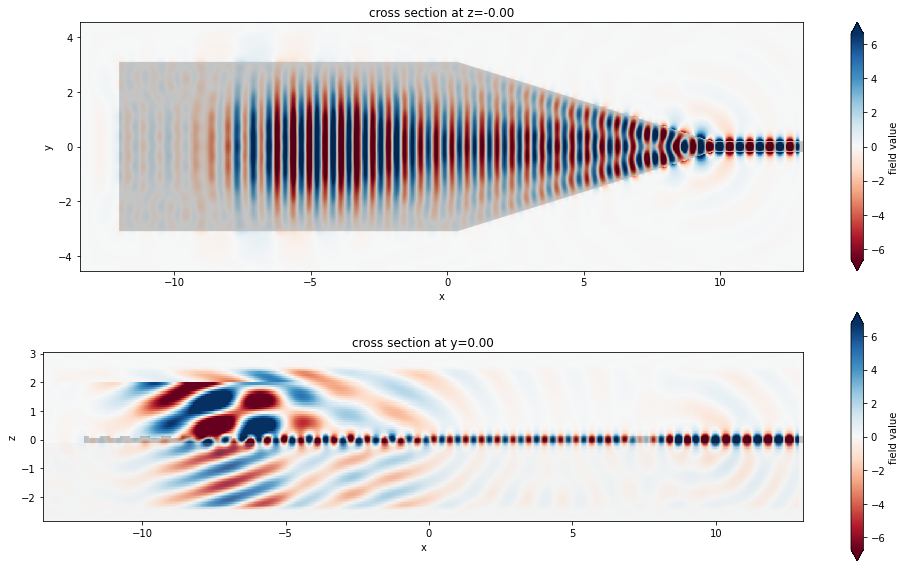

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, tight_layout=True, figsize=(14, 8))
sim_data2.plot_field("full_domain_fields", "Ey", f=freq0, ax=ax1)
sim_data2.plot_field("radiated_fields", "Ey", f=freq0, ax=ax2)


In [24]:
flux = sim_data2["flux"].flux
print(f"flux in waveguide / flux in = {float(flux):.4f} ")


flux in waveguide / flux in = 0.0485 


The coupler has close to 5% in-coupling efficiency, and we did not put any effort into optimizing it beyond just defining the grating pitch to target the correct angle!